Train: (60000, 784) (60000,)
Test : (10000, 784) (10000,)
Epoch 1/10, Accuracy: 92.24%
Epoch 2/10, Accuracy: 94.16%
Epoch 3/10, Accuracy: 95.29%
Epoch 4/10, Accuracy: 96.07%
Epoch 5/10, Accuracy: 96.59%
Epoch 6/10, Accuracy: 96.78%
Epoch 7/10, Accuracy: 97.18%
Epoch 8/10, Accuracy: 97.39%
Epoch 9/10, Accuracy: 97.19%
Epoch 10/10, Accuracy: 97.64%
Overall Accuracy on Test Set: 97.64%


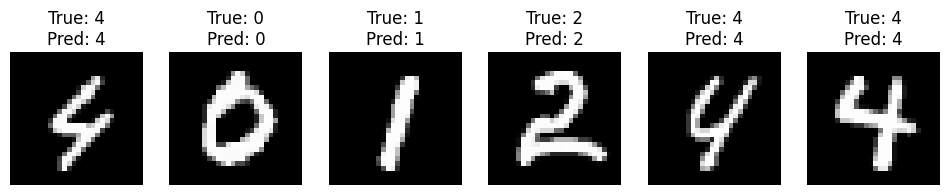

In [2]:
# -----------------------------
# 1. Imports and Data Loading
# -----------------------------
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
import os

# Load images
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num_images = struct.unpack(">II", f.read(8))
        rows, cols = struct.unpack(">II", f.read(8))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows * cols)
        return images.astype(np.float32) / 255.0  # Normalize

# Load labels
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# Set your MNIST raw dataset path
main_path = "C:\\Users\\marth\\Downloads\\ai projects\\MNIST\\raw"

train_images_path = os.path.join(main_path, "train-images-idx3-ubyte.gz")
train_labels_path = os.path.join(main_path, "train-labels-idx1-ubyte.gz")
test_images_path  = os.path.join(main_path, "t10k-images-idx3-ubyte.gz")
test_labels_path  = os.path.join(main_path, "t10k-labels-idx1-ubyte.gz")

# Load the dataset
train_images = load_mnist_images(train_images_path)
train_labels = load_mnist_labels(train_labels_path)
test_images = load_mnist_images(test_images_path)
test_labels = load_mnist_labels(test_labels_path)

print("Train:", train_images.shape, train_labels.shape)
print("Test :", test_images.shape, test_labels.shape)

# -----------------------------
# 2. Simple Neural Network
# -----------------------------
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def compute_loss(self, Y_pred, Y_true):
        m = Y_pred.shape[0]
        log_likelihood = -np.log(Y_pred[np.arange(m), Y_true])
        return np.sum(log_likelihood) / m

    def backward(self, X, Y_true, lr=0.01):
        m = X.shape[0]
        Y_pred = self.a2
        Y_true_one_hot = np.zeros_like(Y_pred)
        Y_true_one_hot[np.arange(m), Y_true] = 1

        dz2 = Y_pred - Y_true_one_hot
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.W2.T) * self.relu_derivative(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

# -----------------------------
# 3. Training the Model
# -----------------------------
X_train, y_train = train_images, train_labels
X_test, y_test = test_images, test_labels

model = SimpleNN(input_size=784, hidden_size=128, output_size=10)
epochs = 10
batch_size = 64

def calculate_accuracy(model, X, y):
    y_pred = model.forward(X).argmax(axis=1)
    return np.mean(y_pred == y)

for epoch in range(epochs):
    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train[permutation]
    
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]

        model.forward(X_batch)
        model.backward(X_batch, y_batch, lr=0.1)

    acc = calculate_accuracy(model, X_test, y_test)
    print(f"Epoch {epoch+1}/{epochs}, Accuracy: {acc * 100:.2f}%")

# Calculate overall accuracy on the test set after training
overall_accuracy = calculate_accuracy(model, X_test, y_test)
print(f"Overall Accuracy on Test Set: {overall_accuracy * 100:.2f}%")

# -----------------------------
# 4. Visualize Predictions
# -----------------------------
def plot_predictions(X, y_true, y_pred, num=6):
    plt.figure(figsize=(12, 4))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_true[i]}\nPred: {y_pred[i]}")
        plt.axis('off')
    plt.show()

sample_idx = np.random.choice(len(X_test), 6, replace=False)
sample_imgs = X_test[sample_idx]
sample_labels = y_test[sample_idx]
predicted = model.forward(sample_imgs).argmax(axis=1)

plot_predictions(sample_imgs, sample_labels, predicted)
